In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

Variable|	Definition	|Key
----|----|----
survival| 	Survival 	|0 = No, 1 = Yes
pclass| 	Ticket class 	|1 = 1st, 2 = 2nd, 3 = 3rd
sex |	Sex 	|
Age |	Age in years 	|
sibsp |	# of siblings / spouses aboard the Titanic 	|
parch |	# of parents / children aboard the Titanic |	
ticket |	Ticket number 	|
fare |	Passenger fare 	|
cabin 	|Cabin number 	|
embarked |	Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton

# Survival Prediction on Titanic

Please read this before doing any analysis:
https://www.kaggle.com/c/titanic/data

In [3]:
gender_submission = pd.read_csv('titanic/gender_submission.csv')
test_df = pd.read_csv('titanic/test.csv')
train_df = pd.read_csv('titanic/train.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


1. Numerical vs Categorical
    - Categorical: Name, Sex, Ticket, Cabin, Embarked
    - We can one-hash 'Sex' column
    - Questions for features:
        - What we can do with Cabin?
        - Can we rebuild the column 'Embarked' with ranked numbers? e.g. 1,2,3
        - Is there anything special with Ticket?
        
2. Incomplete data:
    - Age: what do we do with that? drop? fill?
    - Cabin: many data is missing. should we drop this?

## Exploratory Data Analysis

### Numerical

Take a quick look of the pairplot and see what we can get.

As pairplot will not show categorical information, we are looking at numerical data.

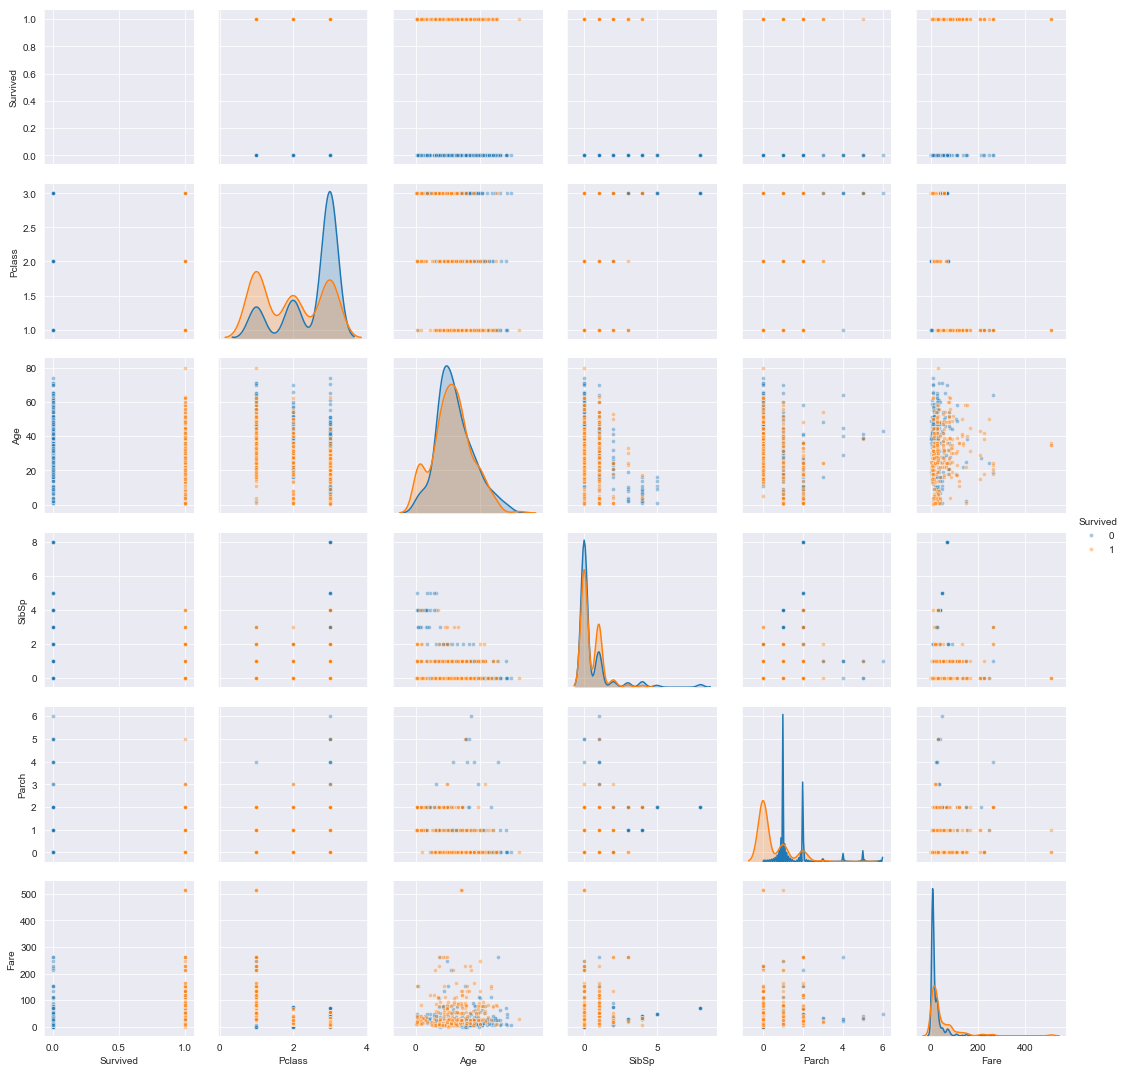

In [73]:
g = sns.pairplot(train_df, hue = 'Survived', diag_kind='auto',
            plot_kws = {'alpha': 0.4, 's': 17},
            vars = ['Survived','Pclass','Age','SibSp','Parch','Fare'])

Diagonal:
- Fare: a peak can be seen. Fatality is quite high when Fare is low.
- Parch: the more parents/children you bring with, the more likely you will sink with the ship <span style="color:red">(which is proved wrong in latter section)
- SibSp: not a clear relationship.
- Age: Children has a higher rate to survive. The older has a higher death rate
- Pclass: Higher class passenger has a lower rate of death

Other:
- Parch vs Age: apparently, if you bing 3 more par/ch w/ you... gg wp. These are middle age persons
- can't see shit!


#### Fare

To show relationship between ticket fare and survival rate,

In [145]:
converted_fare = train_df.Fare.apply(lambda x:x // 10)
train_df['Converted_fare'] = converted_fare

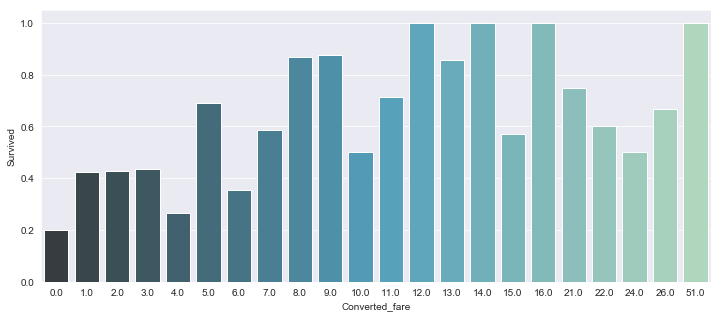

In [161]:
plt.subplots(figsize=(12,5))
sns.barplot('Converted_fare', 'Survived', data=train_df, palette='GnBu_d', ci=None)

We can see some outliers. Later, we need to drop those outliers for accuracy.

In [115]:
df_fare_stats = pd.DataFrame()

In [116]:
df_fare_stats.loc['mean','Survived'] = train_df[train_df.Survived == 1].Fare.mean()
df_fare_stats.loc['std','Survived'] = train_df[train_df.Survived == 1].Fare.std()
df_fare_stats.loc['skew','Survived'] = train_df[train_df.Survived == 1].Fare.skew()
df_fare_stats.loc['kutosis','Survived'] = train_df[train_df.Survived == 1].Fare.kurtosis()

df_fare_stats.loc['mean','Not Survived'] = train_df[train_df.Survived == 0].Fare.mean()
df_fare_stats.loc['std','Not Survived'] = train_df[train_df.Survived == 0].Fare.std()
df_fare_stats.loc['skew','Not Survived'] = train_df[train_df.Survived == 0].Fare.skew()
df_fare_stats.loc['kutosis','Not Survived'] = train_df[train_df.Survived == 0].Fare.kurtosis()

df_fare_stats

,Survived,Not Survived
mean,48.395408,22.117887
std,66.596998,31.388207
skew,3.862779,4.553140
kutosis,20.662030,26.370707


#### Pclass

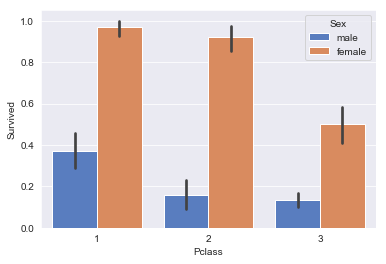

In [38]:
sns.barplot('Pclass','Survived',data=train_df,hue='Sex', palette="muted")

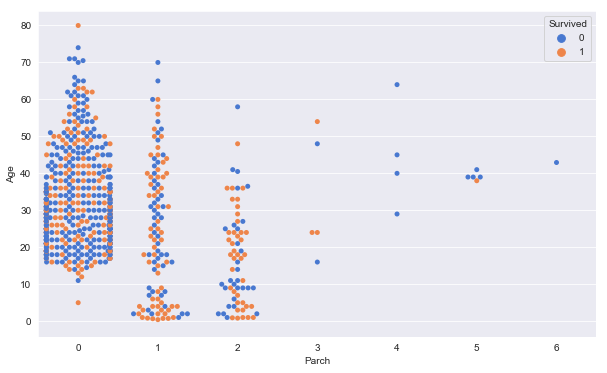

In [47]:
plt.subplots(figsize=(10,6))
sns.swarmplot(x='Parch',y='Age',hue='Survived',data=train_df,size=5,palette='muted')

#### SibSp

In [53]:
train_df.pivot_table(values='Survived',index='SibSp')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


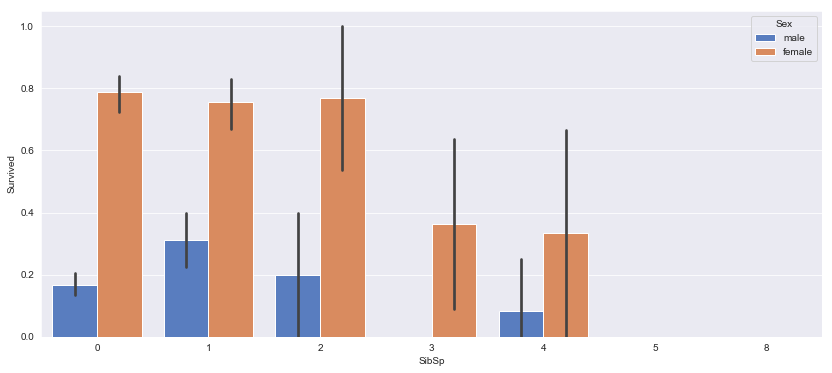

In [49]:
f,axis = plt.subplots(figsize=(14,6))
sns.barplot(x='SibSp',y='Survived',hue='Sex',data=train_df,palette="muted")

#### Parch

In [59]:
train_df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

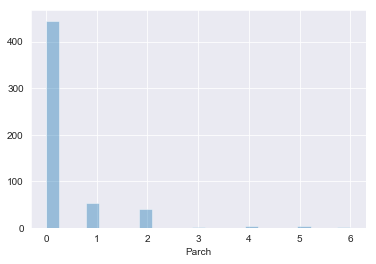

In [81]:
# sns.distplot(train_df.Parch[train_df.Survived == 1], kde=False)
sns.distplot(train_df.Parch[train_df.Survived == 0], kde=False)

In [65]:
train_df.pivot_table(values='Survived',index='Parch',columns='Sex',margins=True)

Sex,female,male,All
Parch,,,
0,0.788660,0.165289,0.343658
1,0.766667,0.327586,0.550847
2,0.612245,0.322581,0.500000
3,0.750000,0.000000,0.600000
4,0.000000,0.000000,0.000000
5,0.250000,0.000000,0.200000
6,0.000000,NaN,0.000000
All,0.742038,0.188908,0.383838


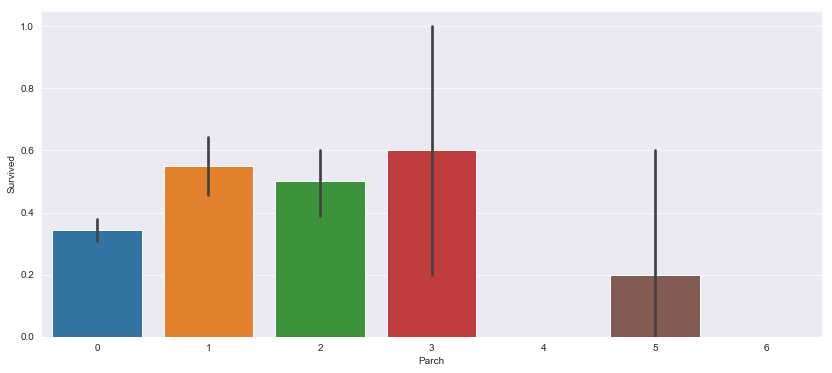

In [40]:
f,axis = plt.subplots(figsize=(14,6))
sns.barplot(x='Parch',y='Survived',data=train_df)

Next, I want to see its relationship with categorical data.

- *Name, Sex, Ticket, Cabin, Embarked*


Actually... I won't talk about names

### Categorical

#### Sex

First of all, have a look of the percentile of sex and survival respectively

In [ ]:
train_df['Sex'].value_counts(normalize=True)

In [ ]:
train_df['Survived'].value_counts(normalize=True)

We have:
- Male takes 65% of the population.
- There is only 38% rate of survival

Then, we plot the count of survival classified by sex:

In [ ]:
sns.barplot(x=train_df['Sex'], y=train_df['Survived'])

We got a stunning result... Is that true? Let me test it.

In [ ]:
train_df[train_df['Sex'] == 'female'].Survived.value_counts(normalize=True)

In [ ]:
train_df[train_df['Sex'] == 'male'].Survived.value_counts(normalize=True)

Ok. It seems we have a strong relationship between sex and survival.
- Male has 18% rate of survival
- Female has 74% rate of survival

#### Ticket

This is a tricky one and I don't wanna go too deep on that, but let's try it anyway. From the numbers, we can know the sequence of booking and something more, but I really don't think this will contribute much on the analysis. 

Instead, let's see what's the survival rate for different strings included in the ticket.

In [ ]:
# replacing all digit with empty strings, and show the result
def replace_digit(x):
    result = ""
    for i in x:
        if not i.isdigit():
            result = "".join([result,i])
    return result.strip()

train_df['Ticket'].apply(replace_digit).value_counts()    

In [ ]:
# save the result in a variable
converted_ticket = train_df['Ticket'].apply(replace_digit)

# create a slicer including top 5 values of the above variable
slicer = train_df['Ticket'].apply(replace_digit).value_counts().index[:10]

In [ ]:
x = []
y = []

for i in slicer:
    print('Testing for {}'.format(i))
    print('Number of data: {}'.format(sum(converted_ticket == i)))
    x.append(i)
    try:
        survival_rate = train_df[converted_ticket == i].Survived.value_counts(normalize=True).loc[1]
        print('The rate of survival is {}'.format(survival_rate))
        y.append(survival_rate)
        
    except:
        print('The rate of survival is 0')
        y.append(0)
        
    print('-'*20)

In [ ]:
f, axis = plt.subplots(figsize=(13,5))
plt.bar(x,y,alpha=0.5)
plt.plot(x,[.38 for x in x],color='red')
axis.set_xlabel('String in Ticket')
axis.set_ylabel('Survival Rate')

As we already know that the rate of survival for the entire training set is 38%, the first result proves that again. The second result shows a **65% of survival rate**. Is that merely a coincidence? We should see correlations between different columns later.

The rest of the results cannot prove anything due to lack of data.

In [ ]:
# we convert the ticket to another column
# will use it later
converted_ticket = converted_ticket.apply(lambda x: 1 if x == 'PC ' else 0)

#### Cabin

Remember, we only have 200+ number of data in Cabin, which only takes 25% of the total.

We've built the replace_digit function before. Great. Now we can use it to the Cabin and do exactly the same as the above.

In [ ]:
train_df.Cabin.apply(lambda x: replace_digit(str(x))).value_counts()

In [ ]:
# save the result in a variable
converted_cabin = train_df['Cabin'].apply(lambda x: replace_digit(str(x)))

# create a slicer including top 5 values of the above variable
slicer = train_df['Cabin'].apply(lambda x: replace_digit(str(x))).value_counts().index[0:]

In [ ]:
x = []
y = []

for i in slicer:
    print('Testing for {}'.format(i))
    print('Number of data: {}'.format(sum(converted_cabin == i)))
    x.append(i)
    try:
        survival_rate = train_df[converted_cabin == i].Survived.value_counts(normalize=True).loc[1]
        print('The rate of survival is {}'.format(survival_rate))
        y.append(survival_rate)
        
    except:
        print('The rate of survival is 0')
        y.append(0)
        
    print('-'*20)

In [ ]:
f, axis = plt.subplots(figsize=(12,5))
plt.bar(x,y,alpha=0.5)
plt.plot(x,[.38 for x in x],color='red')
axis.set_xlabel('String in Ticket')
axis.set_ylabel('Survival Rate')

Very interestingly, We can see the survival rates for Cabin with letters in them all exceed the overall fatality rate. The rest of records that have no Cabin data with them have a lower than overall survival rate - 30%.

#### Embarked

In [ ]:
train_df['Embarked'].value_counts()

In [ ]:
sns.barplot(x=train_df['Embarked'], y=train_df['Survived'])

People embarked at C has a higher rate of survival. We can one hash this column.

## Correlations between data

A heatmap will be great... How we can do that? After feature engineering?

In [ ]:
train_df